# Maintenance prédictive des machines (MPM)

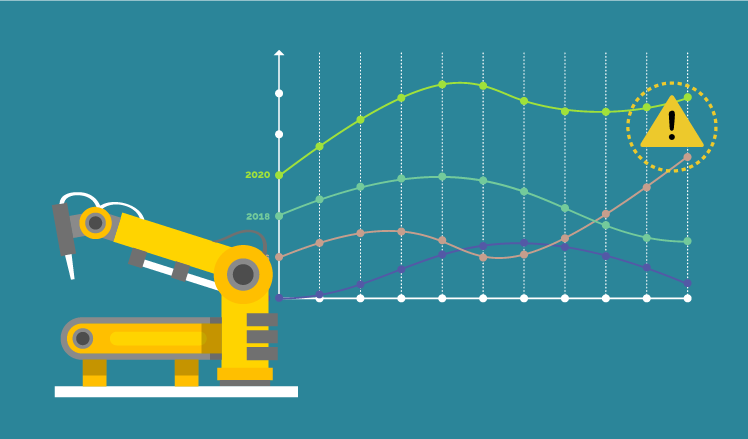

**La maintenance prédictive utilise les données des capteurs pour surveiller un système, puis l'évalue en permanence par rapport aux tendances historiques pour prévoir les pannes avant qu'elles ne surviennent. Grâce à elle nous pouvons assurer :**

**1) Détection d'une anomalie**

**2) Classification des défauts et isolation de la cause racine**

**3) Estimation de la durée de vie restante**

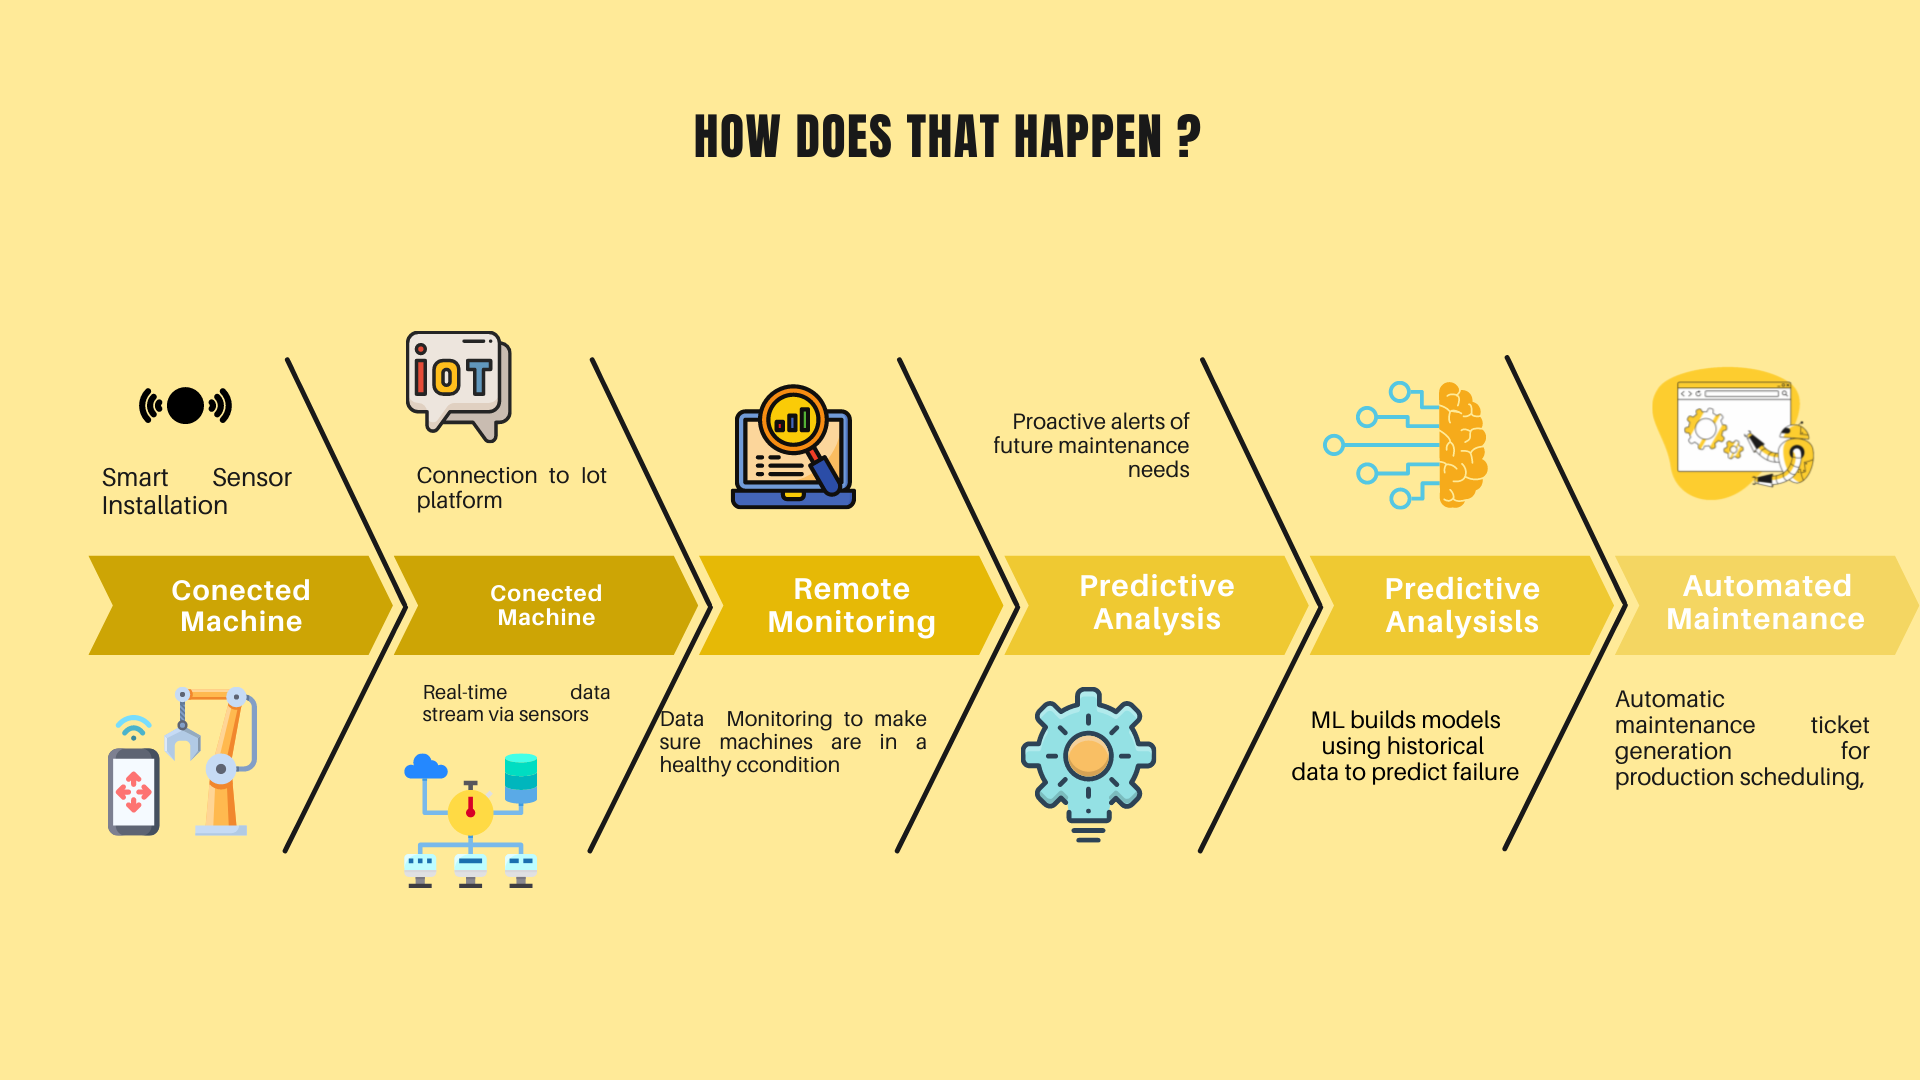

## Détection d'anomalie de défaillance de roulement

### C'est quoi Un roulement ?

**Un roulement est un composant mécanique dont la fonction est de guider un ensemble tournant. Le roulement permet donc la rotation d'un élément par rapport à un autre.**

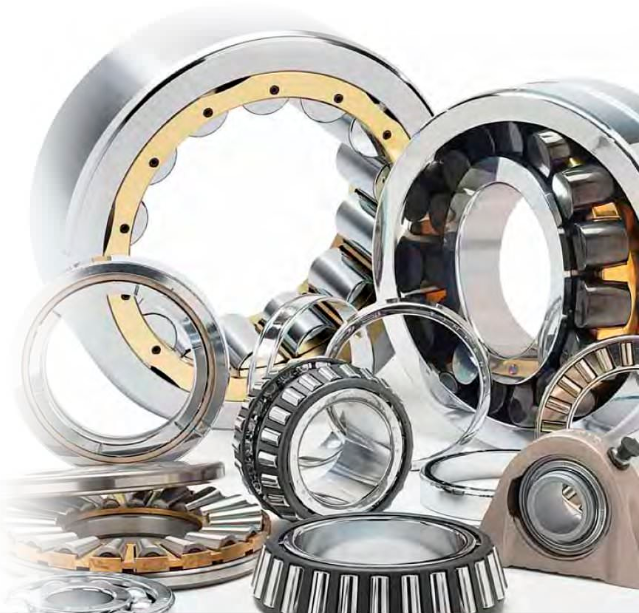

### C'est quoi Un Capteur de roulement ?

**Les capteurs de roulement sont des capteurs autonomes montés à proximité d'un roulement.Ils mesurent généralement la température ou les vibrations et sont principalement utilisés pour la surveillance de l'état.**

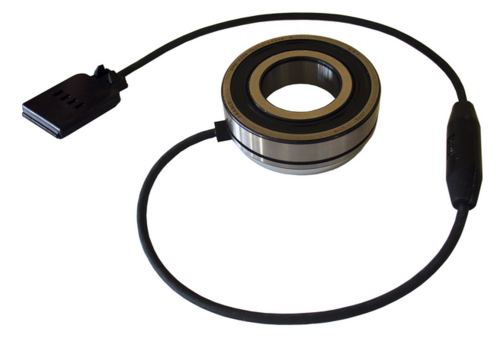

**Chaque ensemble de données se compose de fichiers individuels qui sont des instantanés de signal de vibration d'une seconde enregistrés à des intervalles de 10 minutes. 
Chaque fichier contient 20 480 points de données de capteur qui ont été obtenus en lisant les capteurs de relèvement à une fréquence d'échantillonnage de 20 kHz.**

**Dans ce Notebook , nous utilisons un réseau neuronal d'auto-encodeur pour identifier les anomalies vibratoires à partir des lectures de capteurs dans un ensemble de roulements. L'objectif est de pouvoir prédire les futures défaillances des roulements avant qu'elles ne surviennent.**

In [3]:
# importation des bibliothèques
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline


from numpy.random import seed
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [4]:
# set random seed
seed(10)
tf.random.set_seed(10)

# Chargement et pré-traitement des données


**L'hypothèse est que la dégradation mécanique des roulements se produit progressivement dans le temps ; par conséquent,on va  utiliser un point de données toutes les 10 minutes dans notre analyse.**

In [12]:
# load, average and merge sensor samples


data_dir = r"C:\Users\DELL\Desktop\Maintennace\Bearing_Sensor_Data"
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
#Chaque lecture de capteur de fichier de données de 10 minutes est agrégée en utilisant
#la valeur absolue moyenne des enregistrements de vibrations sur les 20 480 points de données

    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
#Nous fusionnons ensuite le tout en une seule base de données Pandas de 4 bearing (Roulement)    
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']


In [13]:
#First 5 lines of  merged_data
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004.02.12.10.52.39,0.060236,0.074227,0.083926,0.044443
2004.02.12.11.02.39,0.061455,0.073844,0.084457,0.045081
2004.02.12.11.12.39,0.061361,0.075609,0.082837,0.045118
2004.02.12.11.22.39,0.061665,0.073279,0.084879,0.044172
2004.02.12.11.32.39,0.061944,0.074593,0.082626,0.044659


**Commme on peut remarquer les valeurs de date ne sont pas en ordre chrnologique ,Ce qui est défavorable pour une prédiction d'une prédiction anlytique comme la detection d'anomalie ;C'est pour cela  on va transformer l'index du fichier de données en datetime et trier par ordre chronologique**

In [14]:
# transform data file index to datetime and sort in chronological orde
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('Averaged_BearingTest_Dataset.csv')
print("Dataset shape:", merged_data.shape)
merged_data.head()

Dataset shape: (982, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


In [15]:
#First 5 lines of  merged_data after sorting
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


In [16]:
#Last 5 lines of  merged_data
merged_data.tail()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817
2004-02-19 06:12:39,0.001857,0.003732,0.003656,0.001786
2004-02-19 06:22:39,0.001168,0.000767,0.000716,0.001699


# Definir  les jeux d'entraînement / test (train/test data)
**Pour ce faire, nous effectuons une division simple où nous nous entraînons sur la première partie de l'ensemble de données (qui devrait représenter les conditions de fonctionnement normales) et testons les parties restantes de l'ensemble de données menant à la défaillance du roulement.**

In [19]:
train = merged_data['2004-02-12 10:52:39': '2004-02-16 12:52:39'] #3 jours
test = merged_data['2004-02-16 12:52:39':] # Le reste des donneés
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (589, 4)
Test dataset shape: (394, 4)


**Essayer de  traçer les lectures des capteurs de l'ensemble d'apprentissage qui représentent les conditions de fonctionnement normales des roulements.**

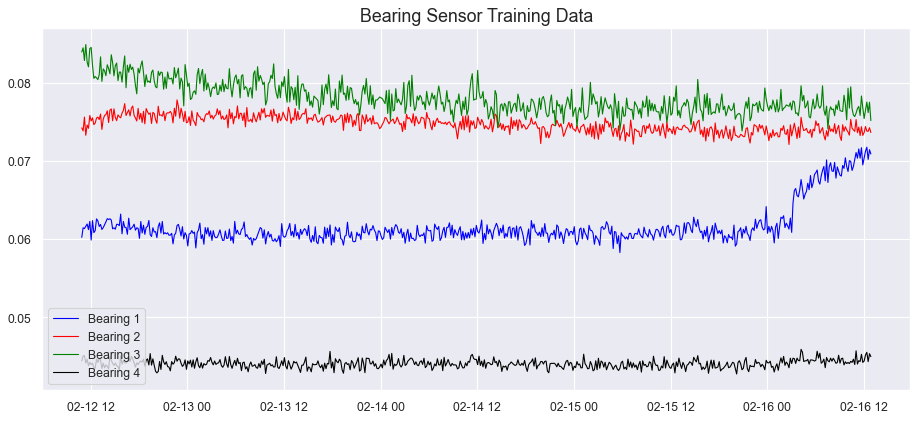

In [33]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')

ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

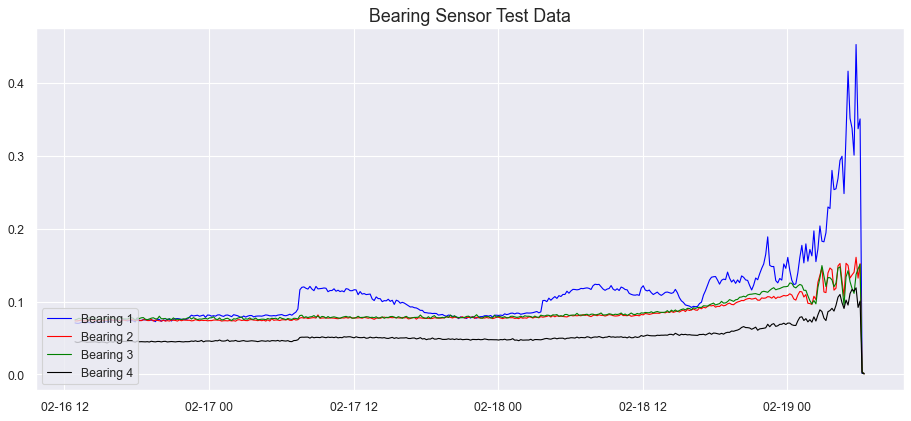

In [32]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Data', fontsize=16)
plt.show()

## Interprétation 

**Au milieu de la période de temps de l'ensemble de test, les modèles de capteur commencent à changer. Près du point de défaillance, les lectures de vibrations des roulements deviennent beaucoup plus fortes et oscillent énormément**

**Pour obtenir une perspective légèrement différente des données, nous allons transformer le signal du domaine temporel au domaine fréquentiel à l'aide d'une transformée de Fourier.**

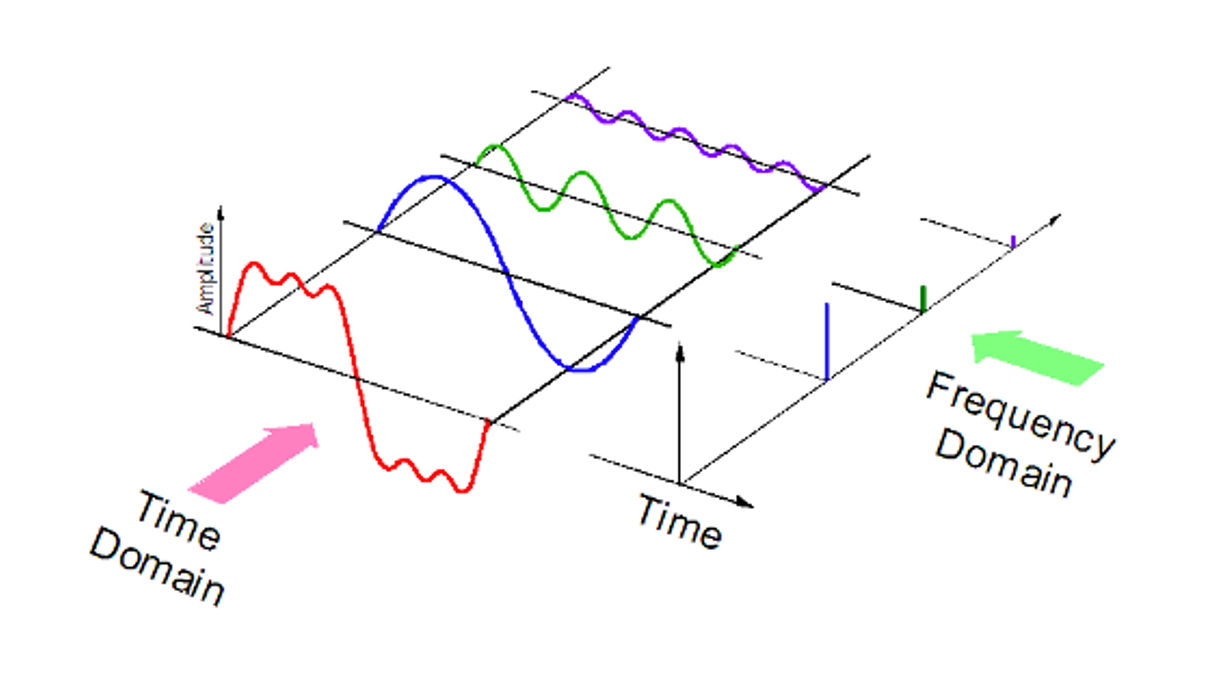

In [25]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

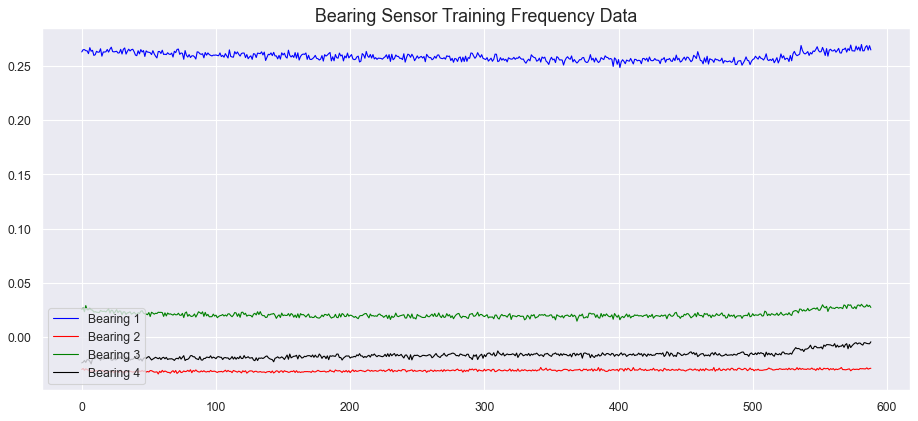

In [34]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

**Il n'y a rien de notable dans les lectures normales du capteur de fonctionnement. Maintenant, regardons les lectures de fréquence du capteur menant à la défaillance du roulement.**

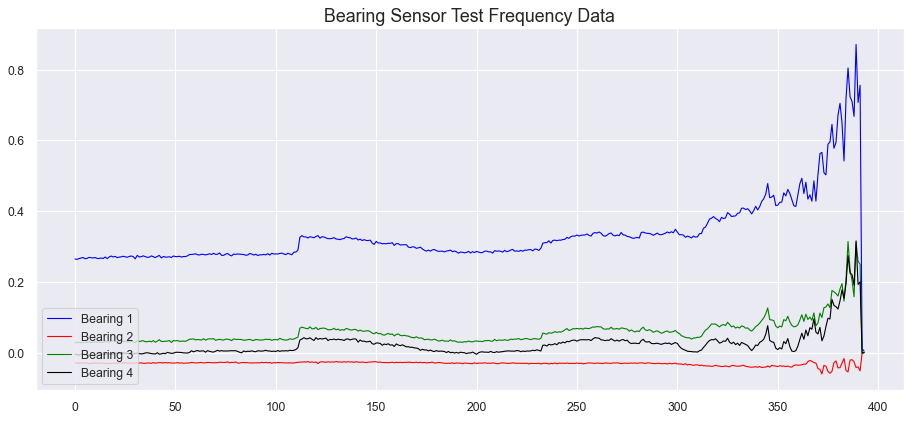

In [35]:
# frequencies of the degrading sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

**Nous pouvons clairement voir une augmentation de l'amplitude de fréquence et de l'énergie dans le système menant aux défaillances des roulements.**

In [40]:
import joblib
# normalize the data

scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [41]:
#Les cellules LSTM attendent un tenseur tridimensionnel de la forme [échantillons de données, pas de temps, caractéristiques].
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (589, 1, 4)
Test data shape: (394, 1, 4)


# WHY LSTM AUTOENCODERS ?

L'architecture de l'auto-encodeur apprend essentiellement une fonction "d'identité". Il prendra les données d'entrée, créera une représentation compressée des principales caractéristiques de conduite de ces données, puis apprendra à les reconstruire à nouveau.

La justification de l'utilisation de cette architecture pour la détection d'anomalies est que nous formons le modèle sur les données "normales" et déterminons l'erreur de reconstruction résultante.

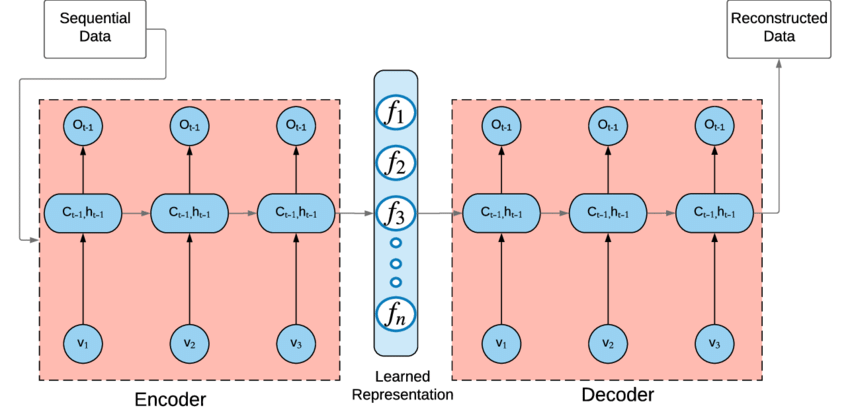

In [42]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [44]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
lstm_5 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 4)              68  

In [50]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1232 - val_loss: 0.2752
Epoch 2/100
56/56 [==============================] - 0s 2ms/step - loss: 0.1231 - val_loss: 0.2753
Epoch 3/100
56/56 [==============================] - 0s 2ms/step - loss: 0.1231 - val_loss: 0.2752
Epoch 4/100
56/56 [==============================] - 0s 2ms/step - loss: 0.1231 - val_loss: 0.2750
Epoch 5/100
56/56 [==============================] - 0s 2ms/step - loss: 0.1231 - val_loss: 0.2751
Epoch 6/100
56/56 [==============================] - 0s 2ms/step - loss: 0.1231 - val_loss: 0.2754
Epoch 7/100
56/56 [==============================] - 0s 2ms/step - loss: 0.1231 - val_loss: 0.2757
Epoch 8/100
56/56 [==============================] - 0s 2ms/step - loss: 0.1231 - val_loss: 0.2760
Epoch 9/100
56/56 [==============================] - 0s 2ms/step - loss: 0.1232 - val_loss: 0.2751
Epoch 10/100
56/56 [==============================] - 0s 2ms/step - loss: 0.1231 - val_loss: 0.2746
Epoch 11/

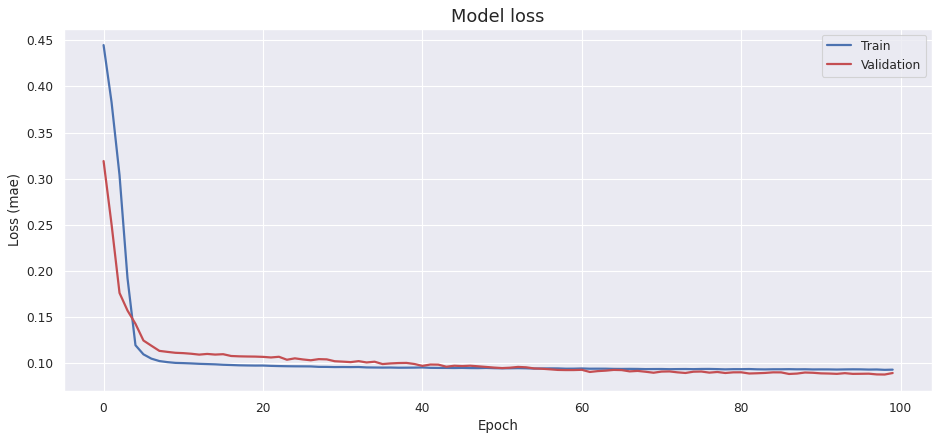

In [15]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

## Distribution de  Loss Function
**En traçons sa distrubition ,nous pouvons déterminer une valeur seuil appropriée pour identifier une anomalie. Ce faisant, on peut s'assurer que ce seuil est fixé au-dessus du « niveau de bruit » afin que les faux positifs ne soient pas déclenchés.**

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

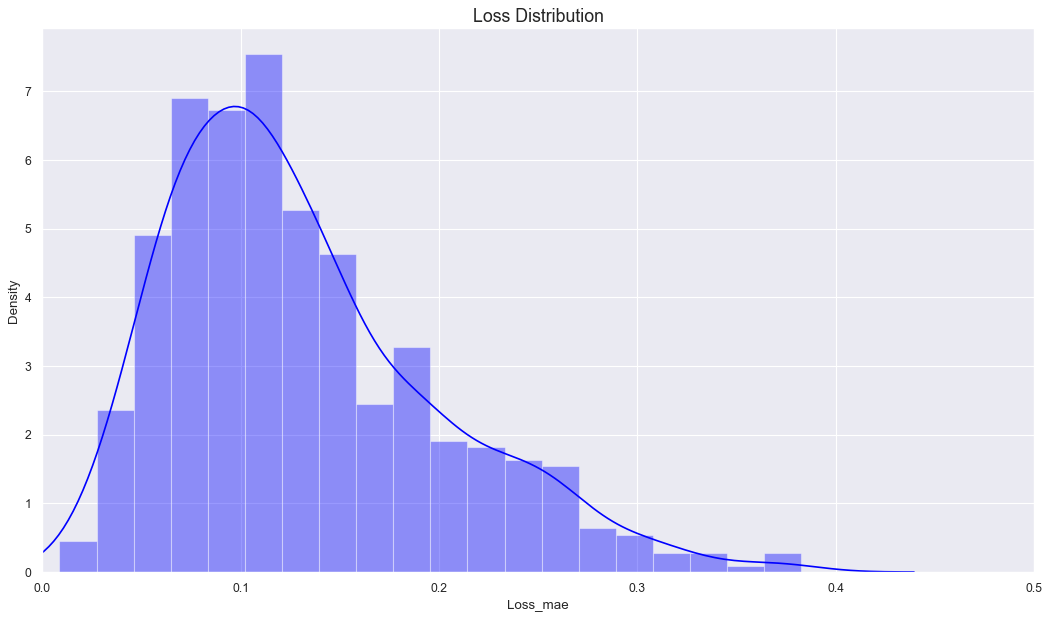

In [59]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

A parti du graphe ci dessus , pn peut essayer une valeur seuil de 0,275 pour signaler une anomalie. Nous calculons ensuite loss dans les ensembles d'apprentissage et de test pour déterminer quand les lectures du capteur franchissent le seuil d'anomalie.

In [60]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2004-02-16 12:52:39,0.369087,0.275,True
2004-02-16 13:02:39,0.274020,0.275,False
2004-02-16 13:12:39,0.227871,0.275,False
2004-02-16 13:22:39,0.349192,0.275,True
2004-02-16 13:32:39,0.318626,0.275,True


In [63]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])
scored.head()

,Loss_mae,Threshold,Anomaly
2004-02-12 10:52:39,0.207051,0.275,False
2004-02-12 11:02:39,0.283785,0.275,True
2004-02-12 11:12:39,0.244826,0.275,False
2004-02-12 11:22:39,0.249732,0.275,False
2004-02-12 11:32:39,0.184942,0.275,False


Après avoir calculerr la distribution de la fonction loss  et du thresahold (seuil d'anomalie), nous pouvons visualiser la sortie du modèle dans le temps précédant la défaillance du roulement.

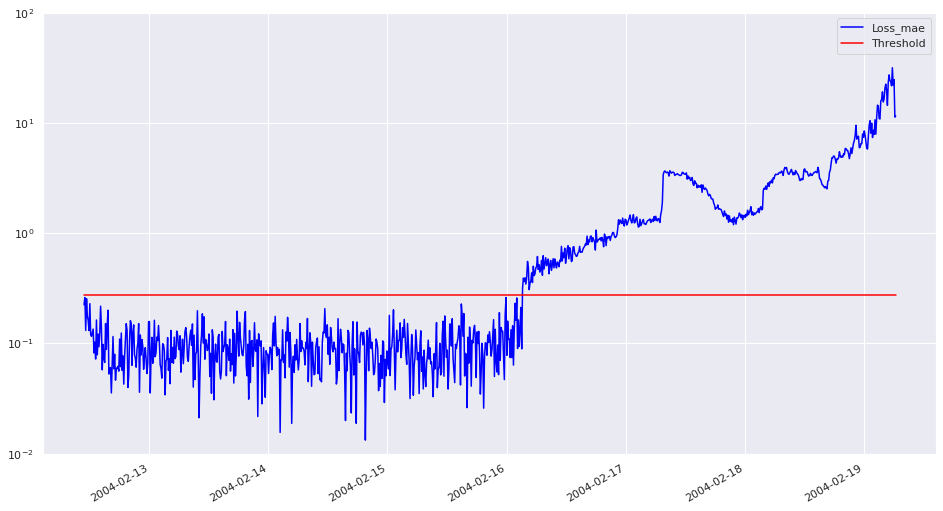

In [19]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red']) # ylim :Set the x limits of the current axes
#logy applique le log sur x 

**Cette approche d'analyse est capable de signaler le dysfonctionnement imminent du roulement bien avant la défaillance physique réelle. Il est important de définir une valeur seuil adaptée pour signaler les anomalies**

In [20]:
# save all model information, including weights, in h5 format
model.save("bearing-sensor-anomaly-detection.h5")
print("Model saved")

Model saved
